## Segmenting and Clustering Neighborhoods in Toronto

#### This notebook will be used for the analysis of the different neighborhoods in the Toronto area as part of the Coursera IBM Data Science Capstone Project

In [3]:
# Import libraries
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library
from bs4 import BeautifulSoup # webscraping and parser library
print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Libraries imported.


## Now to setup the notebook to locate and extract the information

In [19]:
# Using Requests and BeautifulSoup library to extract and format the data
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M' # website containing the information to use
data  = requests.get(url).text # webscrape the data and format as text
soup = BeautifulSoup(data,"html5lib")  # create a soup object using the variable 'data' html doctype
print(soup.prettify())

<!DOCTYPE html>
<html class="client-nojs" dir="ltr" lang="en">
 <head>
  <meta charset="utf-8"/>
  <title>
   List of postal codes of Canada: M - Wikipedia
  </title>
  <script>
   document.documentElement.className="client-js";RLCONF={"wgBreakFrames":!1,"wgSeparatorTransformTable":["",""],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["","January","February","March","April","May","June","July","August","September","October","November","December"],"wgRequestId":"3e153440-8107-4140-8bf0-e27877771ded","wgCSPNonce":!1,"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":!1,"wgNamespaceNumber":0,"wgPageName":"List_of_postal_codes_of_Canada:_M","wgTitle":"List of postal codes of Canada: M","wgCurRevisionId":1032600019,"wgRevisionId":1032600019,"wgArticleId":539066,"wgIsArticle":!0,"wgIsRedirect":!1,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["Articles with short description","Short description is different from Wikidata","Communica

## Breaking down the text document further and organizing by links.

In [22]:
for link in soup.find_all('a',href=True):  # in html anchor/link is represented by the tag <a>

    print(link.get('href'))

#mw-head
#searchInput
/wiki/Postal_codes_in_Canada
/wiki/Toronto
/wiki/Ontario
/wiki/Canada_Post
#cite_note-1
/wiki/Mobile_app
/wiki/Smartphones
/wiki/IPhone
/wiki/BlackBerry
#cite_note-2
/wiki/CD-ROM
/wiki/Toronto
/wiki/Postal_codes_in_Canada#Forward_sortation_areas
/w/index.php?title=List_of_postal_codes_of_Canada:_M&action=edit&section=1
/wiki/Freepost
/wiki/Amazon.ca
/wiki/TSC_(TV_channel)
#cite_note-3
/wiki/North_York
/wiki/Parkwoods
/wiki/North_York
/wiki/Victoria_Village
/wiki/Downtown_Toronto
/wiki/Regent_Park
/wiki/Harbourfront,_Toronto
/wiki/North_York
/wiki/Lawrence_Manor
/wiki/Lawrence_Heights
/wiki/Queen%27s_Park_(Toronto)
/wiki/Etobicoke
/wiki/Islington_Avenue
/wiki/Scarborough,_Toronto
/wiki/Malvern,_Toronto
/wiki/Rouge,_Toronto
/wiki/North_York
/wiki/Don_Mills
/wiki/East_York
/wiki/Parkview_Hill
/wiki/Woodbine_Gardens
/wiki/Downtown_Toronto
/wiki/Garden_District,_Toronto
/wiki/Ryerson_University
/wiki/North_York
/wiki/Etobicoke
/wiki/West_Deane_Park
/wiki/Princess_Garde

## The webpage contains tables.  Using the below commands, the information can be navigated and parsed correctly.
## It lists 103 cells pertaining to the FSAs (Forward Sortation Areas) or Postal Codes in Toronto.

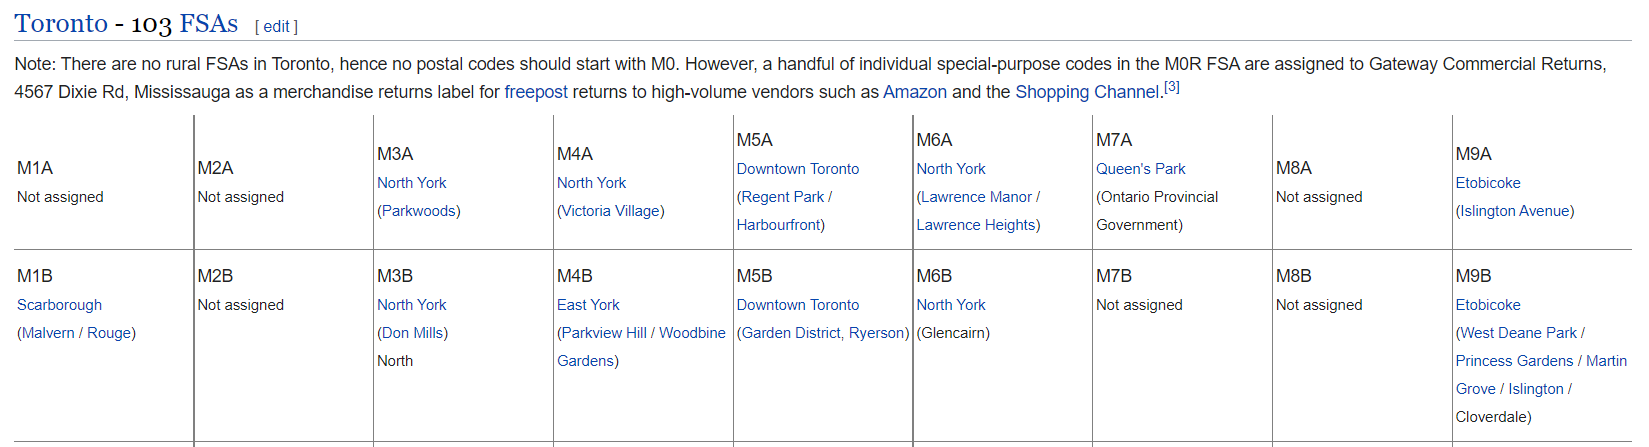

In [23]:
# find all html tables in the web page
tables = soup.find_all('table') # in html table is represented by the tag <table>

In [14]:
# number of tables found by checking the length of the tables list
len(tables)

3

In [26]:
print(tables[table_index].prettify()) # breaks the table down into a html hierarchy.  Each FSA begins with a 'M' and there are no 'M0'

<table cellpadding="2" cellspacing="0" rules="all" style="width:100%;">
 <tbody>
  <tr>
   <td style="width:11%;">
    <p>
     M1A
     <br/>
     <span style="font-size:85%;">
      Not assigned
     </span>
    </p>
   </td>
   <td style="width:11%;">
    <p>
     M2A
     <br/>
     <span style="font-size:85%;">
      Not assigned
     </span>
    </p>
   </td>
   <td style="width:11%;">
    <p>
     M3A
     <br/>
     <span style="font-size:85%;">
      <a href="/wiki/North_York" title="North York">
       North York
      </a>
      <br/>
      (
      <a href="/wiki/Parkwoods" title="Parkwoods">
       Parkwoods
      </a>
      )
     </span>
    </p>
   </td>
   <td style="width:11%;">
    <p>
     M4A
     <br/>
     <span style="font-size:85%;">
      <a href="/wiki/North_York" title="North York">
       North York
      </a>
      <br/>
      (
      <a href="/wiki/Victoria_Village" title="Victoria Village">
       Victoria Village
      </a>
      )
     </span>
    </p>


## Extracting and formating the data using Pandas.

In [45]:
# Creating a data frame 'cell' which will break the data for Toronto into three columns.

cell = ['Postal Code', 'Borough', 'Neighborhood']

table_contents=[]
table=soup.find('table')
for row in table.findAll('td'): # locates a data cell within a table
    cell = {}
    if row.span.text=='Not assigned':  # skips over empty cells
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)

# print(table_contents)
df=pd.DataFrame(table_contents)
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})

In [48]:
df.head() # Display first five rows.

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government


In [47]:
df.shape # Size (rows) in our data table.

(103, 3)

## So far the information has been extracted from Wikipedia, reviewed and parsed, and placed into a data frame.  Using df.shape and len() our data frame is (103, 3) which means we have the correct amount of data.